In [2]:
from torch.utils.data import  DataLoader
from LIDC_data import LIDC_Dataset
import torch,os
import pandas as pd
# import torchio as tio
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F
from torchvision import tv_tensors,utils
from configparser import ConfigParser

In [2]:
import torchvision.models as models
model = models.resnet18(pretrained=True)

/home/vscode/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import shutil
shutil.get_terminal_size()

os.terminal_size(columns=80, lines=24)

In [3]:
bbdf = pd.read_csv('/workspaces/data/lidc-idri/bbox/allbb_noPoly.csv')
traindf = pd.read_csv('/workspaces/data/lidc-idri/splits/train_malB.csv')
traindf[['pid','slice']] = traindf['filename'].apply(lambda x: pd.Series((s:= x.split('.')[-2].split('/'), s[0],'_'.join(s[1].split('_')[:-1]))[1:]))
trainBB = pd.merge(traindf, bbdf.drop_duplicates(), on=['pid','slice'], how='inner')
trainBB.to_csv('/workspaces/data/lidc-idri/splits/trainBB_malB.csv',index=False)
testdf = pd.read_csv('/workspaces/data/lidc-idri/splits/test_malB.csv')
testdf[['pid','slice']] = testdf['filename'].apply(lambda x: pd.Series((s:= x.split('.')[-2].split('/'), s[0],'_'.join(s[1].split('_')[:-1]))[1:]))
testBB = pd.merge(testdf, bbdf.drop_duplicates(), on=['pid','slice'], how='inner')
testBB.to_csv('/workspaces/data/lidc-idri/splits/testBB_malB.csv',index=False)

In [44]:
5496+2355-2

7849

In [2]:
prep_tr = [
    v2.Lambda(lambda x: tv_tensors.Image(torch.clamp(x,-1000.,400.)) if isinstance(x, tv_tensors.Image) else x),
    # tio.Clamp(-1000,400),
    v2.Lambda(lambda x: tv_tensors.Image((x+1000)/1400) if isinstance(x, tv_tensors.Image) else x),
    # tio.RescaleIntensity((0,1), in_min_max=(-1000,400)),
    v2.CenterCrop((384,384)),
    # tio.CropOrPad((1,384,384),padding_mode='minimum')
]

aug_tr = [
    v2.RandomAffine(degrees=15),
    v2.RandomHorizontalFlip(),
    # v2.GaussianNoise(0,0.1)
]
trans0 = v2.Compose( prep_tr + aug_tr )
tr_test=v2.Compose(prep_tr)

In [21]:
trans0

Compose(
      Lambda(<lambda>, types=['object'])
      Lambda(<lambda>, types=['object'])
      CenterCrop(size=(384, 384))
      RandomAffine(degrees=[-15.0, 15.0], interpolation=InterpolationMode.NEAREST, fill=0)
      RandomHorizontalFlip(p=0.5)
)

In [3]:
parser = ConfigParser()
parser.read('.settings')
root_dir = parser.get('dataset','root_dir') #/workspaces/data/lidc-idri/slices
meta_dir = parser.get('dataset','meta_dir') #/workspaces/data/lidc-idri/splits
train_data = LIDC_Dataset(root_dir,metapath=os.path.join(meta_dir,'trainBB_malB.csv'),transform=trans0)
test_data = LIDC_Dataset(root_dir,metapath=os.path.join(meta_dir,'test_malB.csv'),transform=trans0)

# train_data = LIDC_Dataset('/data1/lidc-idri/slices',metapath='/data2/lijin/lidc-prep/kjs/splits/train_malB.csv',transform=trans0)
# test_data = LIDC_Dataset('/data1/lidc-idri/slices',metapath='/data2/lijin/lidc-prep/kjs/splits/test_malB.csv')
total_train_data = len(train_data)
total_test_data = len(test_data)
print('total_train_data:',total_train_data, 'total_test_data:',total_test_data)

total_train_data: 5495 total_test_data: 2354


In [6]:
type(train_raw[0][0])

torchvision.tv_tensors._image.Image

In [50]:
train_raw[0][0][0].float()

tensor([[ -988.,  -987., -1000.,  ...,  -990.,  -999.,  -988.],
        [ -996.,  -988.,  -986.,  ...,  -991.,  -985.,  -989.],
        [-1000.,  -994.,  -989.,  ...,  -973.,  -998.,  -987.],
        ...,
        [ -672.,  -871.,  -902.,  ...,  -988.,  -999.,  -998.],
        [ -285.,  -662.,  -894.,  ...,  -980.,  -981.,  -999.],
        [  143.,  -245.,  -648.,  ...,  -993.,  -998.,  -997.]])

In [51]:
tv_tensors.Image(train_raw[0][0])

Image([[[ -988,  -987, -1000,  ...,  -990,  -999,  -988],
        [ -996,  -988,  -986,  ...,  -991,  -985,  -989],
        [-1000,  -994,  -989,  ...,  -973,  -998,  -987],
        ...,
        [ -672,  -871,  -902,  ...,  -988,  -999,  -998],
        [ -285,  -662,  -894,  ...,  -980,  -981,  -999],
        [  143,  -245,  -648,  ...,  -993,  -998,  -997]]], dtype=torch.int16, )

In [100]:
np.array(train_data[0][2][0]).T.flatten()

array([ 56, 160,  78, 171])

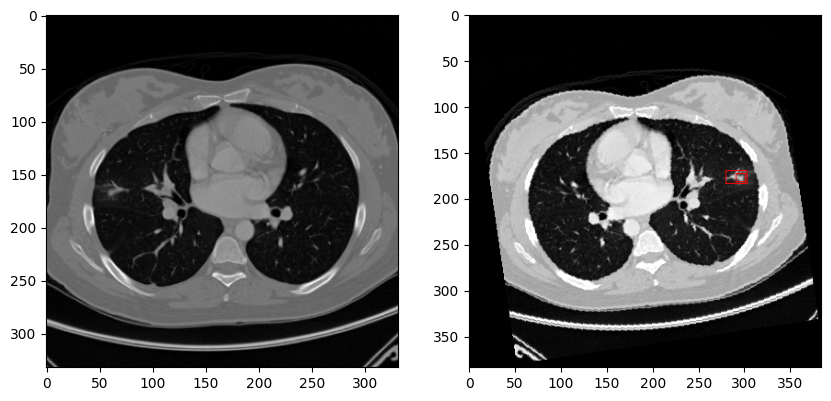

In [4]:
import matplotlib.patches as patches
train_raw = LIDC_Dataset(root_dir,metapath=os.path.join(meta_dir,'trainBB_malB.csv'))
fig, axes = plt.subplots(1,2,figsize=(10, 5))
train_data0 = train_data[0]
img, bbox = train_data0[0], train_data0[2]
axes[0].imshow(train_raw[0][0][0], cmap='gray')
# for box in [ (b:= np.array(p).T, b[0], b[1]-b[0]) for p in train_data[0][2] ] :
#     _, xy, (w, h) = box
#     patch = patches.Rectangle( xy,w,h , edgecolor='green', fill=False, linewidth=1)
#     axes[0].add_patch(patch)

# bboxfl = np.array(train_data[0][2]).transpose(0,2,1)
# bboxes = tv_tensors.BoundingBoxes(bboxfl.reshape(*bboxfl.shape[:-2],-1),format="XYXY",canvas_size=train_raw[0][0][0].shape)
# viz = utils.draw_bounding_boxes(train_data[0][0].float(), boxes=bboxes,colors='red',width=1)
viz = utils.draw_bounding_boxes(img, boxes=bbox,colors='red',width=1)
axes[1].imshow(F.to_pil_image(viz))
#overlay green bounding boxes:
# axes[1].imshow(tfig[0], cmap='gray')

In [12]:
bbox

BoundingBoxes([[ 82, 175, 104, 188],
               [ 83, 179,  93, 187]], format=BoundingBoxFormat.XYXY, canvas_size=(384, 384))

In [10]:
trans0(tv_tensors.Image(train_data[0][0]),
       tv_tensors.BoundingBoxes(train_data[0][2],format="XYXY",canvas_size=train_data[0][0][0].shape))

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 BoundingBoxes([[ 80, 181, 104, 197],
                [ 83, 186,  92, 195]], format=BoundingBoxFormat.XYXY, canvas_size=(384, 384)))

In [116]:
np.array(train_data[0][2]).transpose(0,2,1)

array([[[ 56, 160],
        [ 78, 171]],

       [[ 58, 163],
        [ 67, 171]]])

In [52]:
pd.Series(img.flatten()).describe()

count    147456.000000
mean       -348.187317
std         480.301422
min       -1000.000000
25%        -902.000000
50%         -53.000000
75%           0.000000
max        1268.000000
dtype: float64

In [42]:
image = torch.randint(-1000, 400, (3, 300, 300), dtype=torch.float32)
boxes = torch.tensor([[50, 60, 150, 160]], dtype=torch.float32)  # [xmin, ymin, xmax, ymax]

# Wrap them
image = tv_tensors.Image(image)
bbox = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=image.shape[1:])

# Define transform
transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(p=1.0),  # force for test
    v2.ToDtype(torch.float32, scale=True),  # convert image to float
])

# Apply transform
transformed_image, transformed_boxes = v2.Compose( 
    [
    v2.Lambda(lambda x: tv_tensors.Image(torch.clamp(x,-1000,400)) if isinstance(x, tv_tensors.Image) else x),
    # tio.Clamp(-1000,400),
    v2.Lambda(lambda x: tv_tensors.Image((x+1000)/1400) if isinstance(x, tv_tensors.Image) else x),
    # tio.RescaleIntensity((0,1), in_min_max=(-1000,400)),
    v2.CenterCrop((384,384)),
    # tio.CropOrPad((1,384,384),padding_mode='minimum')
    ]+ aug_tr )(image, bbox)

In [43]:
pd.Series(transformed_image.flatten()).describe()

count    442368.000000
mean          0.304848
std           0.331917
min           0.000000
25%           0.000000
50%           0.180000
75%           0.590000
max           0.999286
dtype: float64

In [14]:
transformed_boxes.canvas_size

(384, 384)

In [8]:
transformed_boxes = tv_tensors.BoundingBoxes([[178.7531,  88.2615, 292.3828, 201.8911]], format="XYXY", canvas_size=(384, 384))

In [17]:
a, b, c, d = transformed_boxes.round().int()[0]
a,b,c,d

(tensor(179, dtype=torch.int32),
 tensor(88, dtype=torch.int32),
 tensor(292, dtype=torch.int32),
 tensor(202, dtype=torch.int32))

In [17]:
trainloader = DataLoader(train_data, batch_size=16, shuffle=True)

In [25]:
d_iter = iter(trainloader)
batch, target = next(d_iter)
target[0].dtype

torch.int64